# Naive Bayes Classifier

## Import Libraries



In [4]:
from datasets import load_dataset
from collections import Counter, defaultdict
import math
import pandas as pd

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/flavien/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Import Dataset

In [5]:
ds = load_dataset("jniimi/tripadvisor-review-rating")
raw_data = pd.DataFrame(ds['train'])

display(raw_data.head())

,hotel_id,user_id,title,text,overall,cleanliness,value,location,rooms,sleep_quality,stay_year,post_date,freq,review,char,lang
0,127781101,2262DCBFC351F42A9DD30AC8BAD24686,Really excellent Hilton,Stayed here on business trips and the hotel is...,5.0,4.0,5.0,4.0,5.0,4.0,2012,2012-04-13,1,Really excellent Hilton\nStayed here on busine...,204,__label__en
1,137380592,8477E11DABF4D6743885E401BB4C8CCF,Exceptional service and comfort,Spent two nights here for a wedding in Brookly...,5.0,5.0,4.0,5.0,4.0,5.0,2012,2012-08-16,1,Exceptional service and comfort\nSpent two nig...,621,__label__en
2,129673371,483A193B7113ADFFD5CE30849564F69C,Nice room and five star service,Great place for a 3-night stay. Our king room ...,5.0,5.0,5.0,3.0,5.0,4.0,2012,2012-05-09,1,Nice room and five star service\nGreat place f...,1259,__label__en
3,129006626,E5A63DD7239A7057746D4644A5C986EB,"BRILLIANT hotel, my #1 Chicago pick for busine...","This is my favorite hotel in Chicago, and I've...",5.0,5.0,5.0,5.0,5.0,5.0,2012,2012-04-28,1,"BRILLIANT hotel, my #1 Chicago pick for busine...",2242,__label__en
4,139168159,CBFE281C9386225267BC52518836A6C2,Convenient and comfortable,BEST. BREAKFAST. EVER. Couldn't have been happ...,5.0,5.0,4.0,5.0,4.0,5.0,2012,2012-09-02,1,Convenient and comfortable\nBEST. BREAKFAST. E...,511,__label__en


In [6]:
print(raw_data.shape)

# Remove the System Prompt
df = raw_data.drop(columns=['stay_year', 'post_date', 'freq', 'lang'])

# Drop the rows with missing User Prompt
df = df.dropna()

# Drop the duplicates
df = df.drop_duplicates()

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test
train_df, test_df = train_test_split(df, test_size=0.2)

train_df, val_df = train_test_split(train_df, test_size=0.2)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(201295, 16)
(128828, 12)
(32208, 12)
(40259, 12)


In [7]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

In [8]:
# Reduce the size of train_df and test_df by taking a random sample
train_df = train_df.sample(frac=0.1, random_state=42)  # Taking 10% of the original data
test_df = test_df.sample(frac=0.1, random_state=42)    # Taking 10% of the original data

print(train_df.shape)
print(test_df.shape)

(12883, 12)
(4026, 12)


In [9]:
X = df['review']
y = df['overall']

X_train, X_test = train_df['review'], test_df['review']
y_train, y_test = train_df['overall'], test_df['overall']

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights

array([5.22636917, 0.46192184, 0.46192184, ..., 0.60200935, 0.60200935,
       1.40567376])

In [10]:

model = make_pipeline(CountVectorizer(ngram_range = (1,1)), MultinomialNB())
# ngram_range=(1, 1) means that the CountVectorizer will consider only unigrams (single words) as features.
#model2 = make_pipeline(CountVectorizer(ngram_range=(1, 1), stop_words=list(en_stop)), MultinomialNB())
model2 = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=lemma_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (2,2)), MultinomialNB())
model3 = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (3,3)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (2,2)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (3,3)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=gpt_tokenize, ngram_range = (1,1)), MultinomialNB())

Features dimension: (12883, 28088)
Classification Report:
               precision    recall  f1-score   support

         1.0       0.78      0.25      0.38       158
         2.0       0.25      0.10      0.14       215
         3.0       0.42      0.41      0.42       579
         4.0       0.54      0.64      0.58      1327
         5.0       0.76      0.76      0.76      1747

    accuracy                           0.62      4026
   macro avg       0.55      0.43      0.46      4026
weighted avg       0.61      0.62      0.60      4026



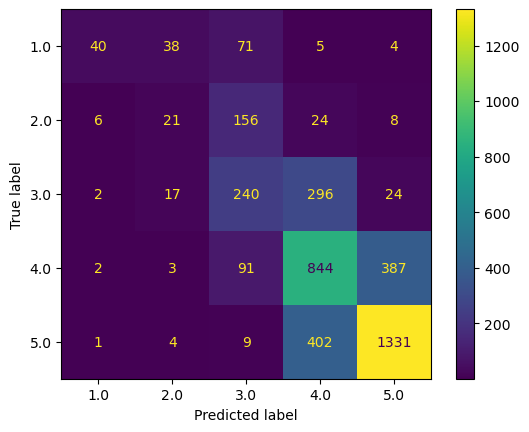

In [11]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# # Perform cross-validation and print the mean accuracy
# scoring = 'f1_macro'
# scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
# print(f"Mean {scoring}: {scores.mean()}")
# print(f"Standard deviation {scoring}: {scores.std()}")

/home/flavien/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features dimension: (12883, 35609)
Classification Report:
               precision    recall  f1-score   support

         1.0       0.82      0.20      0.32       158
         2.0       0.24      0.06      0.09       215
         3.0       0.39      0.36      0.38       579
         4.0       0.52      0.63      0.57      1327
         5.0       0.75      0.77      0.76      1747

    accuracy                           0.60      4026
   macro avg       0.54      0.40      0.42      4026
weighted avg       0.60      0.60      0.59      4026



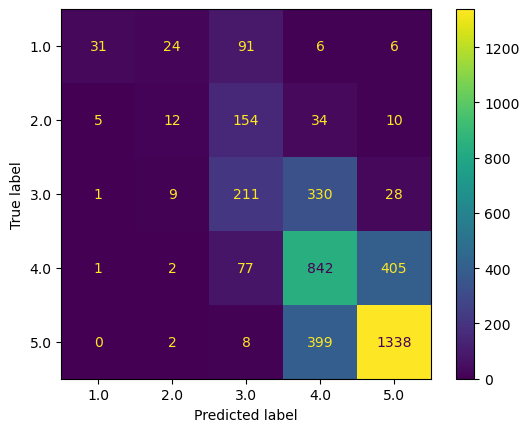

In [12]:
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

print(f"Features dimension: {len(X_train), len(model2[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# # Perform cross-validation and print the mean accuracy
# scoring = 'f1_macro'
# scores = cross_val_score(model2, X, y, cv=5, scoring=scoring, n_jobs = -1)
# print(f"Mean {scoring}: {scores.mean()}")
# print(f"Standard deviation {scoring}: {scores.std()}")

/home/flavien/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features dimension: (12883, 24286)
Classification Report:
               precision    recall  f1-score   support

         1.0       0.62      0.49      0.55       158
         2.0       0.33      0.29      0.31       215
         3.0       0.46      0.46      0.46       579
         4.0       0.54      0.56      0.55      1327
         5.0       0.75      0.75      0.75      1747

    accuracy                           0.61      4026
   macro avg       0.54      0.51      0.52      4026
weighted avg       0.61      0.61      0.61      4026



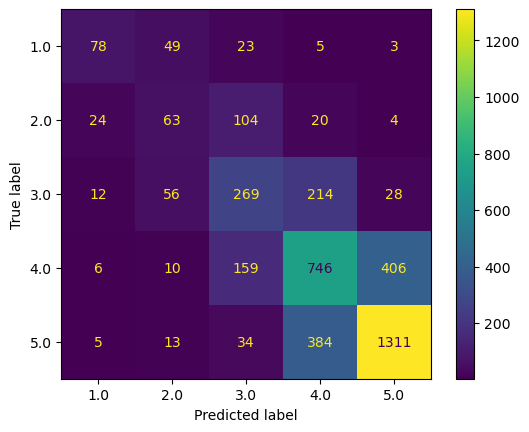

In [13]:
model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)

print(f"Features dimension: {len(X_train), len(model3[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# # Perform cross-validation and print the mean accuracy
# scoring = 'f1_macro'
# scores = cross_val_score(model3, X, y, cv=5, scoring=scoring, n_jobs = -1)
# print(f"Mean {scoring}: {scores.mean()}")
# print(f"Standard deviation {scoring}: {scores.std()}")